## Sparse Mapping of the Second Earth

### -Four main libraries  
**tsv_healpix:** Solver using sparse modeling  (l1-norm + TSV)  
https://web.iem.technion.ac.il/images/user-files/becka/papers/27.pdf  
https://people.rennes.inria.fr/Cedric.Herzet/Cedric.Herzet/Sparse_Seminar/Entrees/2012/11/12_A_Fast_Iterative_Shrinkage-Thresholding_Algorithmfor_Linear_Inverse_Problems_(A._Beck,_M._Teboulle)_files/Breck_2009.pdf  


**tikhonov_solve:** Solver using Tikhonov regularization (l2-norm)  
https://arxiv.org/abs/1204.3504  
https://en.wikipedia.org/wiki/Tikhonov_regularization

**geometry:** Calculating "Transfer Matrix" and related vectors for reflection light  
https://arxiv.org/abs/1204.3504

**log_make.py**  
Libraries for log

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import healpy as hp
import pylab 
import matplotlib.pyplot as plt
import time
from tsv_healpix import *
from tikhonov_solve import *
from geometry import *

## Prepring Folders

##Sructure of Folders##
    
- "folder_root_result"
    - "folder_branch"
        - model: output model saved as "*.npy" (numpy data)
            - cv: models saved in CV process
        - others: cv_result, light_curve, ....
        - figure_map: model figures (albedo map)
        
Change "folder_branch" or "folder_root_result" if you want to make new independent folder



In [11]:
folder_root_result = "./result/" 
folder_branch = "sample_result/"
folder_fig =folder_root_result + folder_branch + "/figure_map/"
folder_log =folder_root_result + folder_branch + "/log/"
folder_model  = folder_root_result + folder_branch + "/model/"


make_folders(folder_root_result, folder_branch)

## Logger make

In [4]:
import log_make
import logging

logger = log_make.log_make("main",folder_log, logging.INFO)


## Loading & Showing Map 

Earth as an Exoplanet: A Two-dimensional Alien Map  
https://arxiv.org/abs/1908.04350

""""  
data: Matrices.npz.fits  
nside in HEALPiX:16  
""""

In [5]:

out = np.load("/Users/masatakaaizawa/github/data/Matrices.npz")

W = out["W"] ## weight matrix
lc = out["O"][:,0] ## light curve 
P = out["P"] ## PC2 at each pixel

M_dmy, M = np.shape(W)
nside = 16

## We offset lightcurve for sparse modeling 
lc_plus = lc -np.min(lc)+0.005
sigma_arr = 1

## Mean value of Weight matrix

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


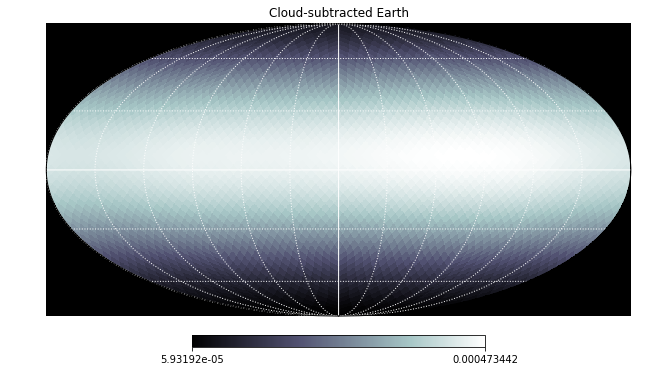

In [9]:

W_mean = np.mean(W,axis = 0)

hp.mollview(W_mean, title="Cloud-subtracted Earth",flip="geo",cmap=plt.cm.bone)#,min=0,max=np.max(np.log(W_mean)))
hp.graticule(color="white");
plt.savefig(folder_fig + "mean_weight.pdf", dpi=200, bbox_inches="tight")
plt.show()


## Sparse mapping
"mfista_func_healpix" is the main function with varying ( lambda_l1,lambda_tsv).  


2019-09-10 13:49:00,138 INFO mfista_func_healpix :l1:-3.50, ltsv:-4.00, Current iteration: 0/1000,  L: 3.501293, cost: 0.185907, cost_chiquare:0.127778, cost_l1:0.026821, cost_ltsv:0.000003
2019-09-10 13:49:04,802 INFO mfista_func_healpix :l1:-3.50, ltsv:-4.00, Current iteration: 50/1000,  L: 2.630573, cost: 0.066110, cost_chiquare:0.033288, cost_l1:0.032805, cost_ltsv:0.000019
2019-09-10 13:49:09,581 INFO mfista_func_healpix :l1:-3.50, ltsv:-4.00, Current iteration: 100/1000,  L: 2.630573, cost: 0.065574, cost_chiquare:0.033428, cost_l1:0.032108, cost_ltsv:0.000035
2019-09-10 13:49:14,279 INFO mfista_func_healpix :l1:-3.50, ltsv:-4.00, Current iteration: 150/1000,  L: 2.630573, cost: 0.065362, cost_chiquare:0.032833, cost_l1:0.032468, cost_ltsv:0.000060
2019-09-10 13:49:18,992 INFO mfista_func_healpix :l1:-3.50, ltsv:-4.00, Current iteration: 200/1000,  L: 2.174027, cost: 0.065320, cost_chiquare:0.032878, cost_l1:0.032358, cost_ltsv:0.000083
2019-09-10 13:49:24,120 INFO mfista_func_he

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


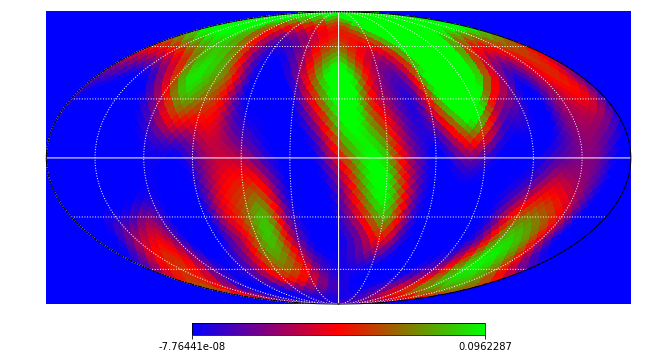

In [12]:
import io
import sys
I_init = np.zeros(M)

## Setting lambda_l1 & lambda_ltsv
lam_tsv_coeff = -4
lam_l1_coeff = -3.5

lambda_tsv = 10**lam_tsv_coeff 
lambda_l1 = 10**lam_l1_coeff## Too large lambda_l1 might fail to solve equations
L_init= lambda_l1 * 10*4 

weight_matrix, test = calc_neighbor_weightmatrix(hp, nside)
I_est = mfista_func_healpix(I_init, lc_plus, W, weight =weight_matrix, L_init = L_init, sigma =sigma_arr, eta = 1.1, lambda_l1 =lambda_l1 , lambda_tsv = lambda_tsv , prox_map =soft_threshold_nonneg_healpix, prox_crit = 0.05, prox_crit_flag = True, maxiter=1000)
np.save(folder_model + "best_model_l1%.1f_ltsv%.1f" % (lam_l1_coeff, lam_tsv_coeff), I_est)
hp.mollview(I_est , title="",flip="geo",cmap=plt.cm.brg,min=np.min(I_est),max=np.max(I_est)/1.5)
hp.graticule(color="white")
plt.savefig(folder_fig + "best_model_l1%.1f_ltsv%.1f.pdf" % (lam_l1_coeff, lam_tsv_coeff), dpi = 200)
